In [237]:
import os
import pandas as pd
from math import ceil
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import seaborn as sns
import numpy as np
from scipy.stats import randint



from sqlalchemy import create_engine
from sqlalchemy import text

from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   FunctionTransformer
                                  )
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error


RANDOM_STATE = 110825
TEST_SIZE = 0.25
PATH_TO_DB = 'ds-plus-final.db'


# Описание проекта

# Загрузка данных

Для более лаконичного исследования таблиц создадим функцию.

In [118]:
# функция выводит первые 5 строк датафрейма, общую информацию и описат.статистики
def func_info(data, table_title):
    print(table_title)
    display(data.head(10))
    display(data.describe())
    data.info()

Создадим движок для подключения к SQLite базе данных.

In [119]:
engine = create_engine(f'sqlite:///{PATH_TO_DB}', echo=False) 

Загрузим таблицы с помощью SQL-запросов:

In [120]:
query = '''
SELECT *
FROM data_arc
'''
#Результат выдачи SQL-запроса можно записать в датафрейм с помощью метода pd.read_sql_query():
data_arc = pd.read_sql_query(query, con = engine) 

func_info(data_arc, 'Данные об электродах (data_arc)')

Данные об электродах (data_arc)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [121]:
query = '''
SELECT *
FROM data_bulk
'''
#Результат выдачи SQL-запроса можно записать в датафрейм с помощью метода pd.read_sql_query():
data_bulk = pd.read_sql_query(query, con = engine) 

func_info(data_bulk, 'данные об объёме сыпучих материалов (data_bulk)')

данные об объёме сыпучих материалов (data_bulk)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
5,6,NaN,NaN,NaN,117.0,None,None,None,None,None,None,None,204.0,None,201.0,154.0
6,7,NaN,NaN,NaN,117.0,None,None,None,None,None,None,None,204.0,None,152.0,154.0
7,8,NaN,NaN,NaN,99.0,None,None,None,None,None,None,None,410.0,None,252.0,153.0
8,9,NaN,NaN,NaN,117.0,None,None,None,None,None,None,None,107.0,None,99.0,203.0
9,10,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,203.0,None,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477
std,933.337642,18.277654,21.180578,75.483494,48.184126
min,1.000000,10.000000,228.000000,6.000000,12.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


In [122]:
query = '''
SELECT *
FROM data_bulk_time
'''
#Результат выдачи SQL-запроса можно записать в датафрейм с помощью метода pd.read_sql_query():
data_bulk_time = pd.read_sql_query(query, con = engine) 

func_info(data_bulk_time, 'данные о времени подачи сыпучих материалов (data_bulk_time)')

данные о времени подачи сыпучих материалов (data_bulk_time)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,None,None,None,2019-05-03 13:57:27,None,None,None,None,None,None,None,2019-05-03 13:48:52,None,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,None,None,None,2019-05-03 14:18:58,None,None,None,None,None,None,None,2019-05-03 14:41:26,None,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,None,None,None,2019-05-03 15:17:58,None,None,None,None,None,None,None,2019-05-03 15:17:58,None,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,None,None,None,2019-05-03 16:03:08,None,None,None,None,None,None,None,2019-05-03 16:03:08,None,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,None,None,None,None,None,None,None,None,None,None,None,2019-05-03 16:38:11,None,2019-05-03 16:34:24,2019-05-03 16:29:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


In [123]:
query = '''
SELECT *
FROM data_gas
'''
#Результат выдачи SQL-запроса можно записать в датафрейм с помощью метода pd.read_sql_query():
data_gas = pd.read_sql_query(query, con = engine) 

func_info(data_gas, 'данные о продувке сплава газом (data_gas)')

данные о продувке сплава газом (data_gas)


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [124]:
query = '''
SELECT *
FROM data_temp
'''
#Результат выдачи SQL-запроса можно записать в датафрейм с помощью метода pd.read_sql_query():
data_temp = pd.read_sql_query(query, con = engine) 

func_info(data_temp, 'данные об измерениях температуры (data_temp)')

данные об измерениях температуры (data_temp)


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


,key
count,18092.000000
mean,1616.460977
std,934.641385
min,1.000000
25%,807.750000
50%,1618.000000
75%,2429.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


In [125]:
query = '''
SELECT *
FROM data_wire
'''
#Результат выдачи SQL-запроса можно записать в датафрейм с помощью метода pd.read_sql_query():
data_wire = pd.read_sql_query(query, con = engine) 

func_info(data_wire, 'данные об объёме проволочных материалов (data_wire)')

данные об объёме проволочных материалов (data_wire)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None
5,6,99.109917,9.11456,None,None,None,None,None,None,None
6,7,98.061600,None,None,None,None,None,None,None,None
7,8,155.282394,None,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376,None,None,None,None,None,None,None


,key,Wire 1
count,3081.000000,3055.000000
mean,1623.426485,100.895853
std,932.996726,42.012518
min,1.000000,1.918800
25%,823.000000,72.115684
50%,1619.000000,100.158234
75%,2434.000000,126.060483
max,3241.000000,330.314424


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


In [126]:
query = '''
SELECT *
FROM data_wire_time
'''
#Результат выдачи SQL-запроса можно записать в датафрейм с помощью метода pd.read_sql_query():
data_wire_time = pd.read_sql_query(query, con = engine) 

func_info(data_wire_time, 'данные о времени подачи проволочных материалов (data_wire_time)')

данные о времени подачи проволочных материалов (data_wire_time)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,None,None,None,None,None,None,None
6,7,2019-05-03 14:18:58,None,None,None,None,None,None,None,None
7,8,2019-05-03 15:01:30,None,None,None,None,None,None,None,None
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,None,None,None,None,None,None,None
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,None,None,None,None,None,None,None


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


# Предобработка и исследовательский анализ данных

Для более лаконичного проведения анализа числовых данных создадим функцию для построения графиков.

In [127]:
def eda_number(data, column, plot_title, x_label):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))  # 2 графика вертикально
    
    # Гистограмма с медианой и средним
    bins = axes[0].hist(data[column], bins=50, color='skyblue', edgecolor='black')
    axes[0].vlines(
        x=data[column].mean(), 
        ymin=0, 
        ymax=bins[0].max(), 
        colors='blue', 
        linestyles='solid', 
        label=f'Среднее = {data[column].mean():.2f}'
    )
    axes[0].vlines(
        x=data[column].median(), 
        ymin=0, 
        ymax=bins[0].max(), 
        colors='red', 
        linestyles='dashed', 
        label=f'Медиана = {data[column].median():.2f}'
    )
    axes[0].set_ylabel('Частота')
    axes[0].set_title(plot_title)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Ящик с усами (boxplot)
    axes[1].boxplot(data[column], vert=False, patch_artist=True)
    axes[1].set_xlabel(x_label)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()  # Автоматическая регулировка отступов
    plt.show()
    
    display(data[column].describe().to_frame().T)  # отображение статистик


## steel.data_arc

In [128]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Наименование колонок не соответствует стилистике, поэтому приведем имена к змеиному типу и переведем на английский язык.

In [129]:
# переименуем столбцы
data_arc.columns = ['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power']

In [130]:
#преобразуем даты в формат datetime
arc_time_columns = ['begin_heat', 'end_heat']
data_arc[arc_time_columns] = data_arc[arc_time_columns].apply(pd.to_datetime, errors='coerce')

In [131]:
data_arc.sort_values(by=['key', 'begin_heat'])

,key,begin_heat,end_heat,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


Для исследования временных признаков и вявления аномалий в них добавим новый признак:
 - время нагрева в секундах;

In [132]:
# Добавим время нагрева в секундах
data_arc['heating_sec'] = (data_arc['end_heat'] - data_arc['begin_heat']).dt.total_seconds()
data_arc.head(10)

,key,begin_heat,end_heat,active_power,reactive_power,heating_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0


Посмотрим на распределение данных.

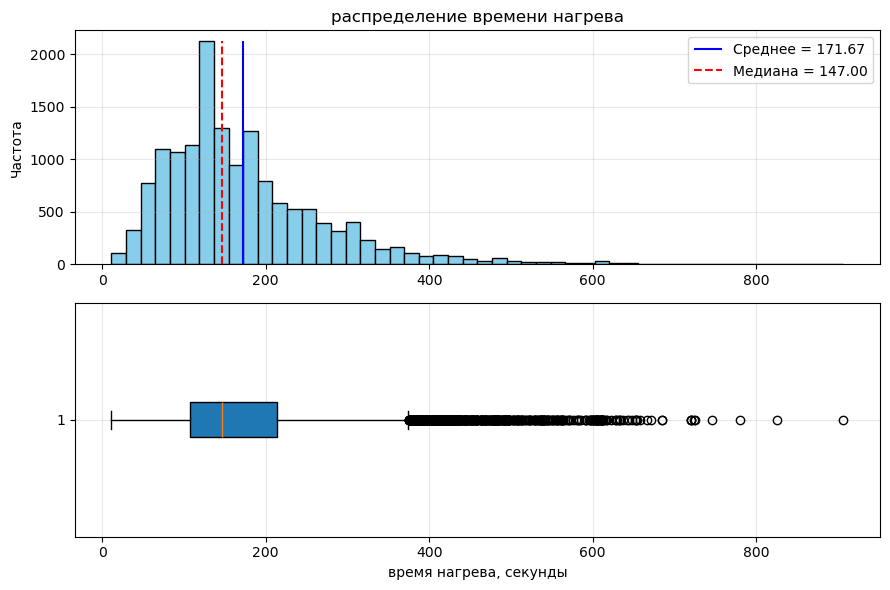

,count,mean,std,min,25%,50%,75%,max
heating_sec,14876.0,171.670946,98.186803,11.0,107.0,147.0,214.0,907.0


In [133]:
#функция для построения графиков
eda_number(data_arc, 
           'heating_sec', 
           'распределение времени нагрева', 
           'время нагрева, секунды')

Из графика и описательных статистик видим , что нет отрицательных значений. Значит, все временные данные идут последовательно , то есть нет такого, что время начала нагрева больше чем время окончания нагрева. Минимальное время нагрева 11 секунд. максимальное 907 секунд. при этом медина 147 секнуд, а среднее 171, то есть данные смещены вправо. 

Пока не будем удалять слишком высокие значения, а добавим метку аномальности.

In [134]:
anomaly_keys = data_arc[data_arc['heating_sec']>600]['key'].unique()

Добавим дополнительные признаки:

 - соотношение активной мощности к реактивной;
 - полную мощность (Полная мощность - это корень квадратный из квадрата активной и реактивной);
 - количество нагревов для каждой партии.

In [135]:
#  соотношение активной мощности к реактивной
data_arc['active_to_reactive_power'] = data_arc['active_power'] / data_arc['reactive_power']

Полная мощность (S) — это гипотенуза в треугольнике мощностей, где катеты — это активная (P) и реактивная (Q) мощности. Она измеряется в Вольт-Амперах (В∙А) и показывает полную нагрузку на сеть, включая как полезную работу, так и бесполезные обменные процессы.

Формула: S = √(P² + Q²)

In [136]:
# считаем полную мощность
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2) ** 0.5

Посмотрим на вновь сформированные признаки и сделаем выбор -  какие признаки использовать в обучении в дальнейшем. 

Посмотрим на распределение данных.

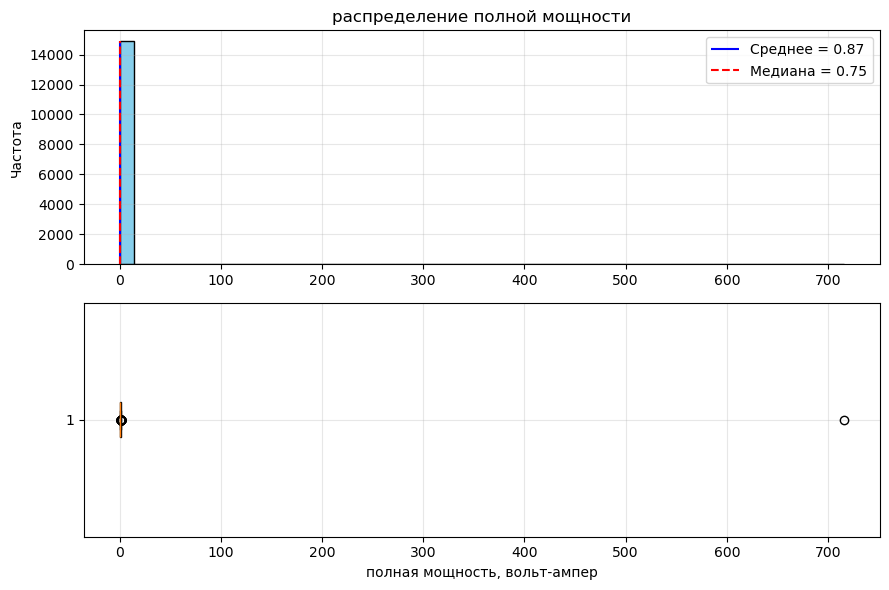

,count,mean,std,min,25%,50%,75%,max
full_power,14876.0,0.871425,5.868339,0.275718,0.578847,0.746591,1.030427,715.480272


In [137]:
#функция для построения графиков
eda_number(data_arc, 
           'full_power', 
           'распределение полной мощности', 
           'полная мощность, вольт-ампер')

Построим график распределения без аномальных партий

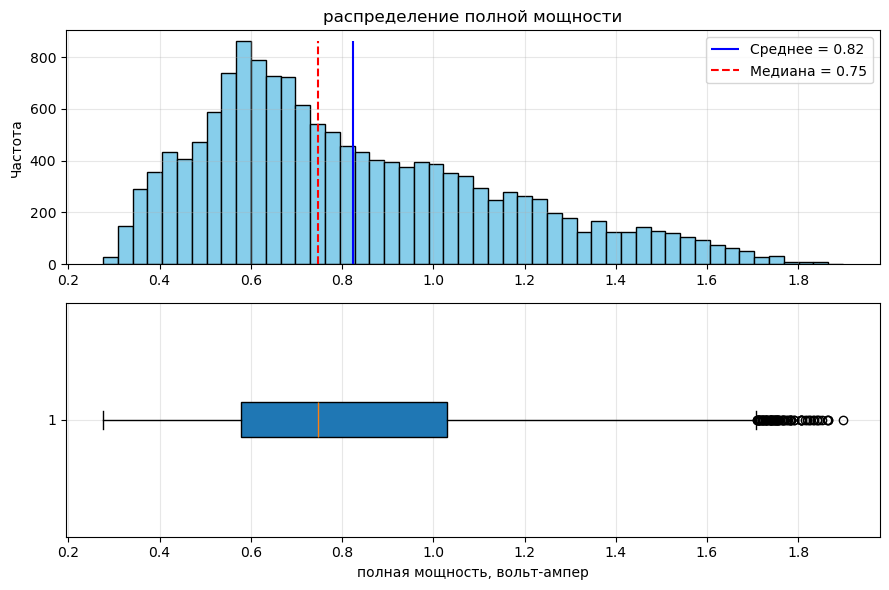

,count,mean,std,min,25%,50%,75%,max
full_power,14875.0,0.823385,0.32347,0.275718,0.578839,0.746554,1.030402,1.898158


In [138]:
#функция для построения графиков
eda_number(data_arc[data_arc['full_power'] < 100], 
           'full_power', 
           'распределение полной мощности', 
           'полная мощность, вольт-ампер')




Видим аномальное значение, скорее всего это ошибка. Пометим всю партию как аномальную. 

In [139]:
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_arc[data_arc['full_power']>100]['key'].unique()
    ])

Посмотрим промежуточное значение количества аномальных партий

In [140]:
print('количество аномальных партий', len(np.unique(anomaly_keys)))
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество аномальных партий 60


Добавим количество нагревов для каждой партии:

In [141]:
data_arc['heating_count'] = data_arc.groupby('key')['key'].transform('count')
data_arc.head(10)

,key,begin_heat,end_heat,active_power,reactive_power,heating_sec,active_to_reactive_power,full_power,heating_count
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,1.444382,0.371123,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,1.603680,0.902319,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,1.348123,0.722536,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,1.364539,0.642824,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.347126,1.079934,5
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,1.729622,0.440239,4
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0,1.273142,0.332731,4
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0,1.464645,0.860064,4
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0,1.449396,0.955315,4
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,1.342109,1.373863,5


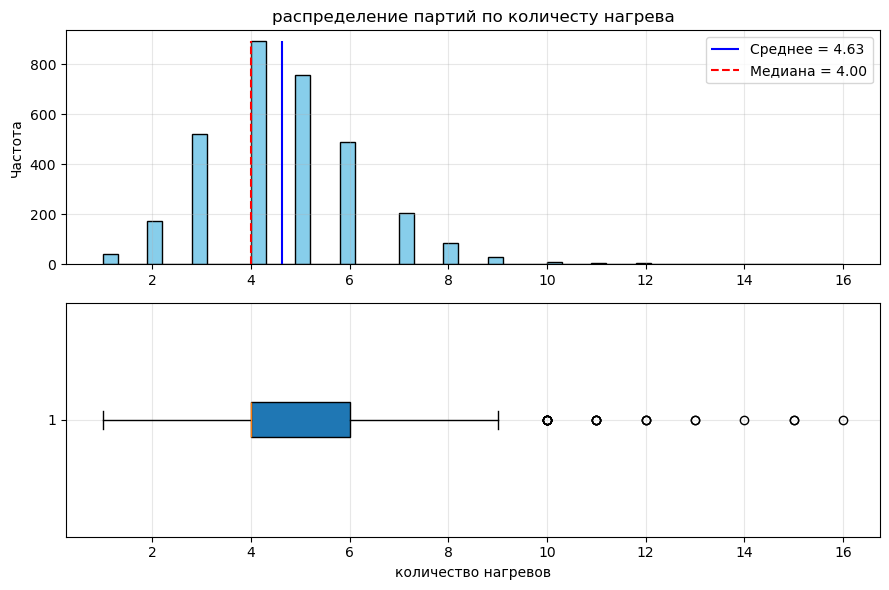

,count,mean,std,min,25%,50%,75%,max
heating_count,3214.0,4.6285,1.608647,1.0,4.0,4.0,6.0,16.0


In [142]:
#функция для построения графиков
eda_number(data_arc.groupby('key')['heating_count'].median().reset_index(), 
           'heating_count', 
           'распределение партий по количесту нагрева', 
           'количество нагревов')


Партии  с 10 и более нагревами скорее всего являются аномальными, добавим их в список аномальных партий.

In [143]:
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_arc[data_arc['heating_count']>10]['key'].unique()
    ])

Посмотрим промежуточное значение количества аномальных партий

In [144]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 11


Агрегируем данные по партиям. 

In [145]:
data_arc = data_arc.groupby('key').agg(
    begin_heat_min=('begin_heat', 'first'),
    end_heat_max=('end_heat', 'last'),
    heating_sec=('heating_sec', 'sum'),
    active_to_reactive_power=('active_to_reactive_power', 'mean'), 
    full_power=('full_power', 'sum'),
    heating_count=('heating_count', 'median')
).reset_index()

In [146]:
data_arc.head(10)

,key,begin_heat_min,end_heat_max,heating_sec,active_to_reactive_power,full_power,heating_count
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1098.0,1.421570,3.718736,5.0
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,811.0,1.479201,2.588349,4.0
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,655.0,1.396069,5.019223,5.0
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,741.0,1.307446,3.400038,4.0
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,869.0,1.328894,2.816980,4.0
5,6,2019-05-03 13:46:51,2019-05-03 14:09:24,952.0,1.424454,3.313074,4.0
6,7,2019-05-03 14:16:46,2019-05-03 14:41:15,673.0,1.366910,3.283913,4.0
7,8,2019-05-03 14:53:56,2019-05-03 15:17:48,913.0,1.339344,3.405956,4.0
8,9,2019-05-03 15:36:43,2019-05-03 16:02:49,625.0,1.402228,4.335261,5.0
9,10,2019-05-03 16:14:09,2019-05-03 16:37:51,825.0,1.448822,3.791005,6.0


## steel.data_bulk

In [147]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


In [148]:
data_bulk.columns = data_bulk.columns.str.replace(' ', '_').str.lower()

Приведем данные к числовому типу данных изаменим пропуски на 0.

In [149]:
# создадим список колонок , в которых необходимо изменить тип данных
bulk_columns = [
    'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
    'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'
]

In [150]:
# меняем тип данных
data_bulk[bulk_columns] = data_bulk[bulk_columns].apply(pd.to_numeric)

In [151]:
#заполняем пропуски
data_bulk = data_bulk.fillna(0)

In [152]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Для выявления аномальных значений выведем максимальное и минимальне значение по каждой партии и посчитаем разницу.

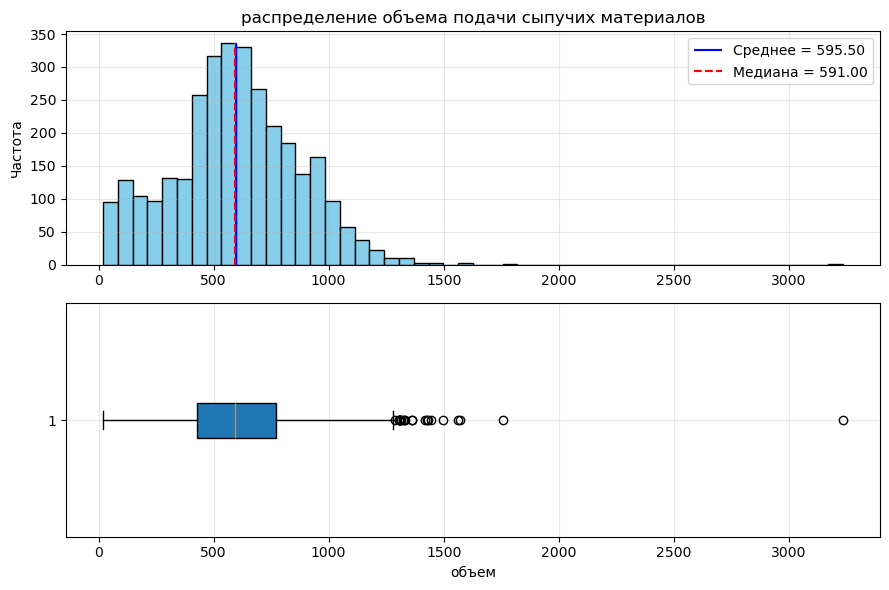

,count,mean,std,min,25%,50%,75%,max
bulk_sum,3129.0,595.503356,276.557794,19.0,429.0,591.0,772.0,3235.0


In [153]:
#найдем общее количекство сыпучих материалов по каждой партии
data_bulk['bulk_sum'] = data_bulk[bulk_columns].sum(axis=1)

#функция для построения графиков
eda_number(data_bulk, 
           'bulk_sum', 
           'распределение объема подачи сыпучих материалов', 
           'объем') 

Добавим партии со слишком большим значением объема сыпучих материаолов в список аномальных.

In [154]:
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_bulk[data_bulk['bulk_sum']>1500]['key'].unique()
])

Уберем из таблицы лишние признаки.

In [155]:
data_bulk = data_bulk.drop(['bulk_sum'], axis=1)

Посмотрим промежуточное значение количества аномальных партий

In [156]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 2


In [157]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [158]:
len(data_bulk['key'].unique())

3129

Данные уже агрегированы по партиям , поэтому этого делать не придется.

## steel.data_bulk_time

In [159]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


In [160]:
len(data_bulk_time['key'].unique())

3129

In [161]:
#переименуем столбцы - приведем их к змеиному типу
data_bulk_time.columns = data_bulk_time.columns.str.replace(' ', '_').str.lower()
data_bulk_time.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [162]:
#преобразуем даты в формат datetime
data_bulk_time[bulk_columns] = data_bulk_time[bulk_columns].apply(pd.to_datetime, errors='coerce')

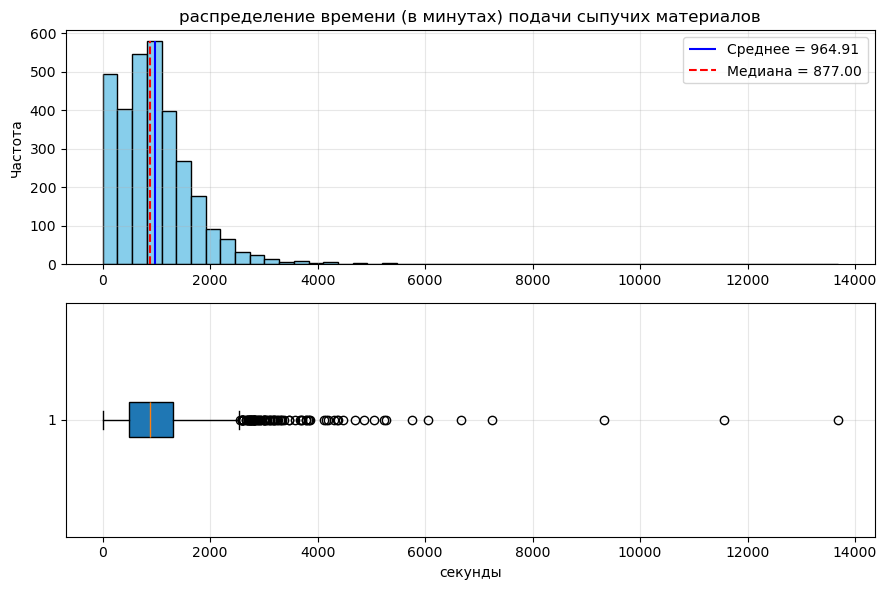

,count,mean,std,min,25%,50%,75%,max
bulk_delta_sec,3129.0,964.906679,798.088025,0.0,485.0,877.0,1311.0,13683.0


In [163]:
#найдем максимальную и минимальную дату для каждой партии и найдем между ними разницу
data_bulk_time['bulk_max_date'] = data_bulk_time[bulk_columns].max(axis=1)
data_bulk_time['bulk_min_date'] = data_bulk_time[bulk_columns].min(axis=1)
data_bulk_time['bulk_delta_sec'] = (data_bulk_time['bulk_max_date'] - data_bulk_time['bulk_min_date']).dt.total_seconds()

#функция для построения графиков
eda_number(data_bulk_time, 
           'bulk_delta_sec', 
           'распределение времени (в минутах) подачи сыпучих материалов', 
           'секунды')


Уберем из таблицы лишние признаки.

In [164]:
data_bulk_time = data_bulk_time.drop(bulk_columns, axis=1)

Партии со временем подачи материалов более 100 минут определим как аномальные и добавим их в список.

In [165]:
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_bulk_time[data_bulk_time['bulk_delta_sec']>6000]['key'].unique()
])

Посмотрим промежуточное значение количества аномальных партий

In [166]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 4


In [167]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             3129 non-null   int64         
 1   bulk_max_date   3129 non-null   datetime64[ns]
 2   bulk_min_date   3129 non-null   datetime64[ns]
 3   bulk_delta_sec  3129 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 97.9 KB


In [168]:
len(data_bulk_time['key'].unique())

3129

Данные уже агрегированы по партиям , поэтому этого делать не придется.

## steel.data_gas

In [169]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Переименуем столбцы

In [170]:
data_gas.columns = ['key', 'gas']

Посмотрим на распределение данных

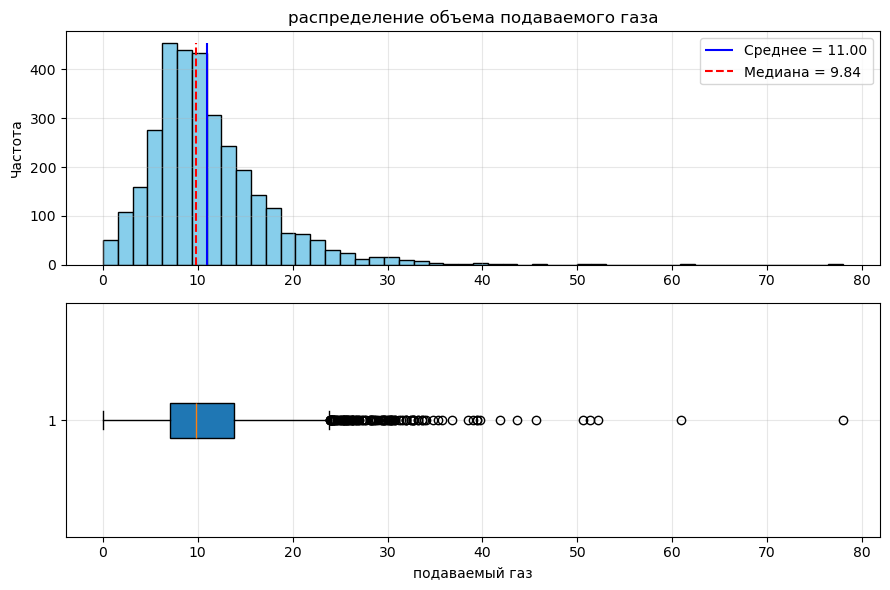

,count,mean,std,min,25%,50%,75%,max
gas,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


In [171]:
#функция для построения графиков
eda_number(data_gas, 
           'gas', 
           'распределение объема подаваемого газа', 
           'подаваемый газ')

Объем подаваемого газа более 50 будем считать аномальным , поэтому партии с таким объемом внесем в список.  

In [172]:
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_gas[data_gas['gas']>50]['key'].unique()
])

Посмотрим промежуточное значение количества аномальных партий

In [173]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 4


In [174]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [175]:
len(data_gas['key'].unique())

3239

Данные уже агрегированы по партиям , поэтому этого делать не придется.

## steel.data_temp

In [176]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


Переименуем столбцы

In [177]:
data_temp.columns = ['key', 'time_mesure', 'temperature']

Пока не будем заполнять пропуски нулями , так как нам нужны конечные значения температуры, а они могут быть не пустыми. А если мы заполним пропуски нулями , то в следующем шаге партии с такими нулями попадут в список аномальных

Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные, поэтому эти партии сразу внесем в список аномальных.

In [178]:
data_temp['temperature'] = pd.to_numeric(data_temp['temperature'], errors='coerce')
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_temp[data_temp['temperature']<1500]['key'].unique()
])

In [179]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          18092 non-null  int64  
 1   time_mesure  18092 non-null  object 
 2   temperature  14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [180]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 5


In [181]:
#преобразуем даты в формат datetime
data_temp['time_mesure'] = pd.to_datetime(data_temp['time_mesure'])

In [182]:
#найдем максимальную и минимальную дату и соответствуюющую температуру для каждой партии и найдем между датами  разницу в секундах
data_temp = data_temp.sort_values(['key', 'time_mesure'])
data_temp = data_temp.groupby('key').agg(
    first_temperature=('temperature', 'first'),
    temp_min_date=('time_mesure', 'first'),
    target=('temperature', 'last'),
    temp_max_date=('time_mesure', 'last')
).reset_index()

data_temp['temp_delta_sec'] = (data_temp['temp_max_date'] - data_temp['temp_min_date']).dt.total_seconds()

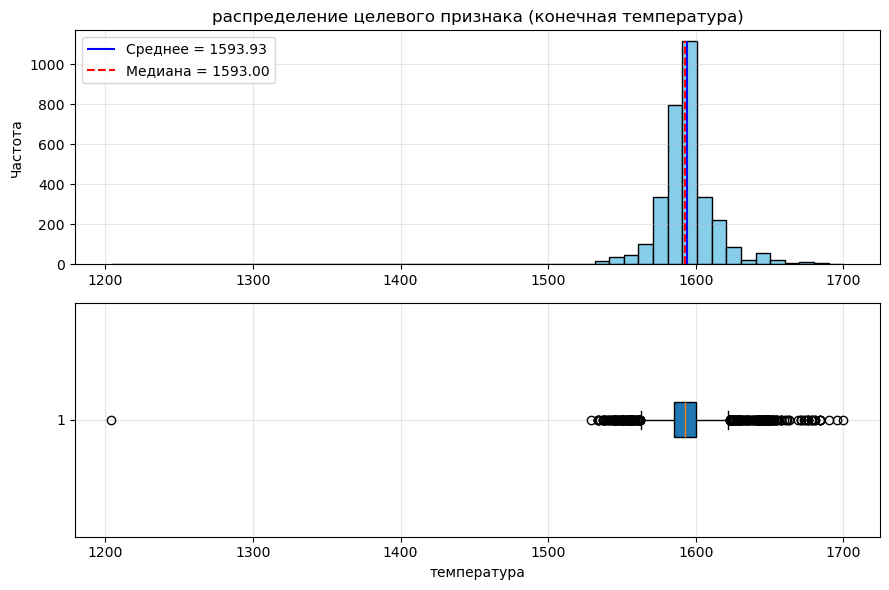

,count,mean,std,min,25%,50%,75%,max
target,3216.0,1593.928483,19.874627,1204.0,1585.0,1593.0,1600.0,1700.0


In [216]:
#функция для построения графиков
eda_number(data_temp, 
           'target', 
           'распределение целевого признака (конечная температура)', 
           'температура')

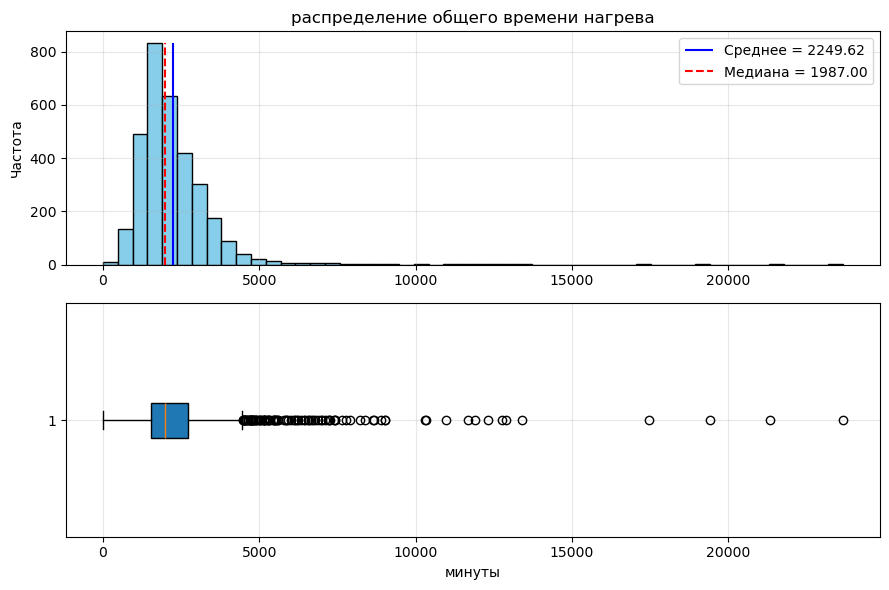

,count,mean,std,min,25%,50%,75%,max
temp_delta_sec,3216.0,2249.620958,1317.270815,0.0,1528.0,1987.0,2706.0,23674.0


In [183]:
#функция для построения графиков
eda_number(data_temp, 
           'temp_delta_sec', 
           'распределение общего времени нагрева', 
           'минуты')

Определим партии с общим временем нагрева более 15 000 секунд как аномальные.

In [184]:
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_temp[data_temp['temp_delta_sec']>15000]['key'].unique()
])

In [185]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 1


после агрегации пропусков в данных не осталось, значит, ни в начальных ни в конечных замерах температуры не было пропусков.

In [186]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                3216 non-null   int64         
 1   first_temperature  3216 non-null   float64       
 2   temp_min_date      3216 non-null   datetime64[ns]
 3   target             3216 non-null   float64       
 4   temp_max_date      3216 non-null   datetime64[ns]
 5   temp_delta_sec     3216 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 150.9 KB


In [187]:
len(data_temp['key'].unique())

3216

Дополнительная агрегация не требуется.

## steel.data_wire

In [188]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


Переименуем столбцы, приведем их к змеиному стилю.

In [189]:
data_wire.columns = data_wire.columns.str.replace(' ', '_').str.lower()

Приведем данные к числовому типу данных изаменим пропуски на 0.

In [190]:
# создадим список колонок , в которых необходимо изменить тип данных
wire_columns = [
    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
    'wire_6', 'wire_7', 'wire_8', 'wire_9'
]

In [191]:
# меняем тип данных
data_wire[wire_columns] = data_wire[wire_columns].apply(pd.to_numeric)

In [192]:
#заполняем пропуски
data_wire = data_wire.fillna(0)

In [193]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Для выявления аномальных значений выведем максимальное и минимальне значение проволочных материалов по каждой партии и посчитаем разницу.

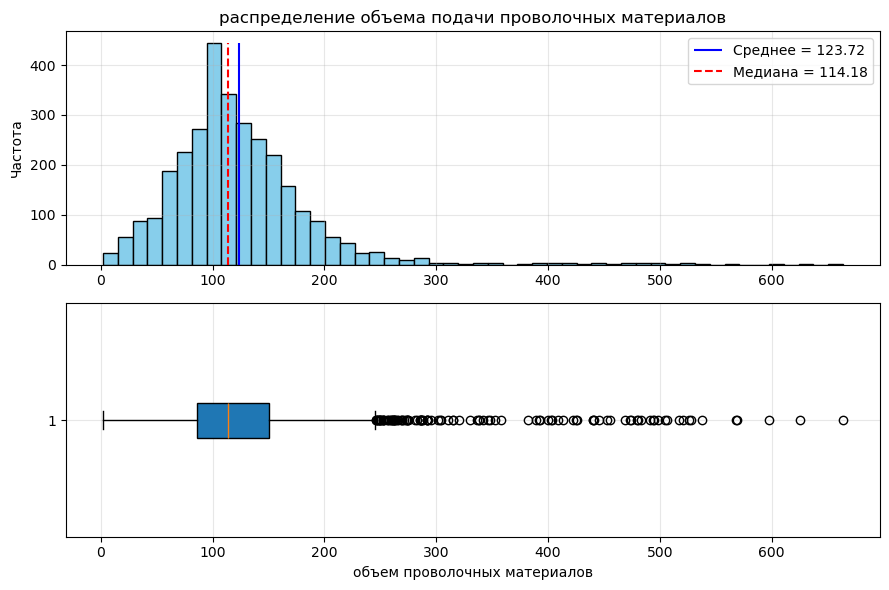

,count,mean,std,min,25%,50%,75%,max
wire_sum,3081.0,123.723326,66.082966,1.9188,86.112,114.179523,150.181198,663.851766


In [194]:
#найдем общнее количество проволочных материалов
data_wire['wire_sum'] = data_wire[wire_columns].sum(axis=1)

#функция для построения графиков
eda_number(data_wire, 
           'wire_sum', 
           'распределение объема подачи проволочных материалов', 
           'объем проволочных материалов') 

Добавим партии с  высоким значением проволочных материалов (>300) в список аномальных партий.

In [195]:
anomaly_keys = np.concatenate([
    anomaly_keys,
    data_wire[data_wire['wire_sum']>600]['key'].unique()
])

Посмотрим промежуточное значение количества аномальных партий

In [196]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 2


Уберем из таблицы лишние признаки.

In [197]:
data_wire = data_wire.drop('wire_sum', axis=1)

In [198]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [199]:
len(data_wire['key'].unique())

3081

Дополнительная агрегация не требуется.

## steel.data_wire_time

In [200]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [201]:
len(data_wire_time['key'].unique())

3081

In [202]:
#переименуем столбцы - приведем их к змеиному типу
data_wire_time.columns = data_wire_time.columns.str.replace(' ', '_').str.lower()
data_wire_time.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


In [203]:
#преобразуем даты в формат datetime
data_wire_time[wire_columns] = data_wire_time[wire_columns].apply(pd.to_datetime, errors='coerce')

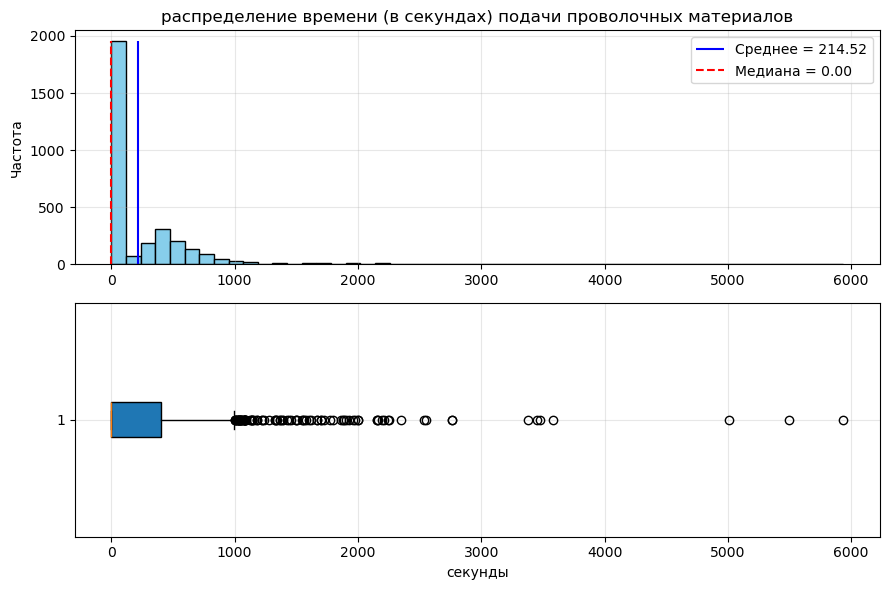

,count,mean,std,min,25%,50%,75%,max
wire_delta_sec,3081.0,214.519312,396.131967,0.0,0.0,0.0,401.0,5937.0


In [204]:
#найдем максимальную и минимальную дату для каждой партии и найдем между ними разницу
data_wire_time['wire_max_date'] = data_wire_time[wire_columns].max(axis=1)
data_wire_time['wire_min_date'] = data_wire_time[wire_columns].min(axis=1)
data_wire_time['wire_delta_sec'] = (data_wire_time['wire_max_date'] - data_wire_time['wire_min_date']).dt.total_seconds()


#функция для построения графиков
eda_number(data_wire_time, 
           'wire_delta_sec', 
           'распределение времени (в секундах) подачи проволочных материалов', 
           'секунды')


Уберем из таблицы лишние признаки.

In [205]:
data_wire_time = data_wire_time.drop(wire_columns, axis=1)

Ранее мы определяли партии со временем подачи материалов более 100 минут как аномальные. Здесь Максимальное время 98.95 минут. Поэтому не будем поплнять список аномальных партий.

Посмотрим промежуточное значение количества аномальных партий

In [206]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 0


In [207]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             3081 non-null   int64         
 1   wire_max_date   3081 non-null   datetime64[ns]
 2   wire_min_date   3081 non-null   datetime64[ns]
 3   wire_delta_sec  3081 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 96.4 KB


In [208]:
len(data_wire_time['key'].unique())

3081

Дополнительная агрегация не требуется.

## Объединение таблиц

In [209]:
df = data_arc.merge(data_bulk_time, on='key', how='inner')
df = df.merge(data_wire_time, on='key', how='inner')
df = df.merge(data_gas, on='key', how='inner')
df = df.merge(data_temp, on='key', how='inner')
df = df.merge(data_bulk, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')


In [210]:
func_info(df, 'Объединенная таблица')

Объединенная таблица


,key,begin_heat_min,end_heat_max,heating_sec,active_to_reactive_power,full_power,heating_count,bulk_max_date,bulk_min_date,bulk_delta_sec,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1098.0,1.421570,3.718736,5.0,2019-05-03 11:28:48,2019-05-03 11:10:43,1085.0,...,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,811.0,1.479201,2.588349,4.0,2019-05-03 11:53:30,2019-05-03 11:36:50,1000.0,...,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,655.0,1.396069,5.019223,5.0,2019-05-03 12:32:39,2019-05-03 12:16:16,983.0,...,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,741.0,1.307446,3.400038,4.0,2019-05-03 12:58:00,2019-05-03 12:43:22,878.0,...,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,869.0,1.328894,2.816980,4.0,2019-05-03 13:34:12,2019-05-03 13:30:47,205.0,...,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,2019-05-03 13:46:51,2019-05-03 14:09:24,952.0,1.424454,3.313074,4.0,2019-05-03 14:09:42,2019-05-03 13:48:52,1250.0,...,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,2019-05-03 14:16:46,2019-05-03 14:41:15,673.0,1.366910,3.283913,4.0,2019-05-03 14:41:26,2019-05-03 14:18:58,1348.0,...,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,2019-05-03 14:53:56,2019-05-03 15:17:48,913.0,1.339344,3.405956,4.0,2019-05-03 15:17:58,2019-05-03 15:05:33,745.0,...,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,2019-05-03 15:36:43,2019-05-03 16:02:49,625.0,1.402228,4.335261,5.0,2019-05-03 16:03:08,2019-05-03 15:52:39,629.0,...,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,2019-05-03 16:14:09,2019-05-03 16:37:51,825.0,1.448822,3.791005,6.0,2019-05-03 16:38:11,2019-05-03 16:29:56,495.0,...,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,key,begin_heat_min,end_heat_max,heating_sec,active_to_reactive_power,full_power,heating_count,bulk_max_date,bulk_min_date,bulk_delta_sec,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3022.000000,3022,3022,3022.000000,3022.000000,3022.000000,3022.000000,3022,3022,3022.000000,...,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000
mean,1623.313038,2019-07-05 19:08:31.582726656,2019-07-05 19:41:21.187954944,801.683322,1.373364,4.106928,4.698875,2019-07-05 19:41:29.743216384,2019-07-05 19:25:04.621111808,985.122105,...,118.701853,100.306762,17.555999,3.950168,0.266115,0.005007,1.159907,0.036542,0.337154,0.246959
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:28:37,57.000000,0.980967,0.331897,1.000000,2019-05-03 11:28:48,2019-05-03 11:10:43,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,821.250000,2019-06-04 13:54:13.249999872,2019-06-04 14:37:43.750000128,576.500000,1.331222,2.832145,4.000000,2019-06-04 14:37:55.500000,2019-06-04 14:13:12,512.000000,...,0.000000,71.436301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1618.500000,2019-07-03 02:18:06.500000,2019-07-03 02:33:35.500000,776.000000,1.373950,3.754065,5.000000,2019-07-03 02:31:37,2019-07-03 02:31:37,890.500000,...,106.000000,100.151993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2429.750000,2019-08-07 23:09:48.249999872,2019-08-07 23:33:19.249999872,987.000000,1.416914,4.769792,6.000000,2019-08-07 23:33:37.249999872,2019-08-07 23:12:41.500000,1330.000000,...,204.000000,125.863920,23.159760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,2019-09-06 16:49:05,2019-09-06 17:26:15,4189.000000,1.663366,717.937368,16.000000,2019-09-06 17:26:33,2019-09-06 17:23:15,13683.000000,...,405.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,62.025600
std,931.884924,NaN,NaN,331.577570,0.065901,13.075797,1.604155,NaN,NaN,802.236393,...,83.389774,42.746214,33.306307,30.600083,4.335435,0.275264,9.043740,0.781697,4.435119,3.040308


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3022 entries, 0 to 3021
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   key                       3022 non-null   int64         
 1   begin_heat_min            3022 non-null   datetime64[ns]
 2   end_heat_max              3022 non-null   datetime64[ns]
 3   heating_sec               3022 non-null   float64       
 4   active_to_reactive_power  3022 non-null   float64       
 5   full_power                3022 non-null   float64       
 6   heating_count             3022 non-null   float64       
 7   bulk_max_date             3022 non-null   datetime64[ns]
 8   bulk_min_date             3022 non-null   datetime64[ns]
 9   bulk_delta_sec            3022 non-null   float64       
 10  wire_max_date             3022 non-null   datetime64[ns]
 11  wire_min_date             3022 non-null   datetime64[ns]
 12  wire_delta_sec      

Проверим нет ли аномальных партий по хронологии этапов плавки. Каждый процесс начинается с замера температуры, поэтому temp_min_date должна быть самой минимальной

In [211]:
#mask = (df['temp_min_date']>df['begin_heat_min']) 
#       | (df['temp_min_date']>df['bulk_min_date']) 
#       | (df['temp_min_date']>df['wire_min_date'])
compare_cols_min = ['begin_heat_min', 'bulk_min_date', 'wire_min_date']
compare_cols_max = ['end_heat_max', 'bulk_max_date', 'wire_max_date']
list_masks = [
    (df['temp_min_date'] > df[col_min]) & (df['temp_max_date'] < df[col_max])
    for col_min, col_max in zip(compare_cols_min, compare_cols_max)
    ]
mask = list_masks[0] | list_masks[1] | list_masks[2]

anomaly_keys = np.concatenate([
    anomaly_keys,
    df[mask]['key'].unique()
])

Посмотрим промежуточное значение количества аномальных партий

In [212]:
print('количество вновь добавившихся аномальных партий', len(np.unique(anomaly_keys)) - temp_anomaly_keys_count)
temp_anomaly_keys_count = len(np.unique(anomaly_keys)) 

количество вновь добавившихся аномальных партий 0


In [213]:
len(np.unique(anomaly_keys))

89

Посмотрим на аномальные партии:

In [214]:
func_info(df[df['key'].isin(anomaly_keys)], 'Аномальные партии')

Аномальные партии


,key,begin_heat_min,end_heat_max,heating_sec,active_to_reactive_power,full_power,heating_count,bulk_max_date,bulk_min_date,bulk_delta_sec,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
41,44,2019-05-04 23:26:33,2019-05-05 02:28:23,2063.0,1.383977,8.981145,12.0,2019-05-05 02:28:41,2019-05-05 01:52:02,2199.0,...,159.0,69.189123,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
43,46,2019-05-05 03:52:56,2019-05-05 07:16:34,2919.0,1.328999,11.591736,13.0,2019-05-05 07:16:45,2019-05-05 06:45:30,1875.0,...,204.0,100.245593,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
67,77,2019-05-06 08:20:17,2019-05-06 09:04:36,1216.0,1.364684,5.044587,6.0,2019-05-06 09:04:53,2019-05-06 08:40:45,1448.0,...,203.0,110.292000,45.135998,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
98,117,2019-05-07 21:50:53,2019-05-07 22:54:17,804.0,1.425090,5.102765,6.0,2019-05-07 22:54:29,2019-05-07 22:32:04,1345.0,...,0.0,0.000000,0.000000,93.068977,0.000000,0.0,26.975523,0.0,0.000000,0.0
99,118,2019-05-07 22:57:35,2019-05-08 01:46:39,1357.0,1.378894,6.258693,6.0,2019-05-08 01:46:58,2019-05-08 01:25:11,1307.0,...,0.0,0.000000,0.000000,94.990898,33.182243,0.0,60.025684,0.0,0.000000,0.0
168,189,2019-05-10 18:04:42,2019-05-10 18:47:53,1334.0,1.343227,4.433043,5.0,2019-05-10 18:48:09,2019-05-10 18:36:30,699.0,...,203.0,74.212318,64.180481,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
248,280,2019-05-14 11:12:55,2019-05-14 12:03:04,1807.0,1.444702,5.191116,9.0,2019-05-14 12:03:22,2019-05-14 11:46:48,994.0,...,0.0,160.174557,76.236166,0.000000,0.000000,0.0,0.000000,0.0,46.002319,0.0
279,312,2019-05-15 12:04:31,2019-05-15 12:42:40,1521.0,1.414695,5.450769,6.0,2019-05-15 12:42:59,2019-05-15 12:34:04,535.0,...,154.0,149.079834,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
289,322,2019-05-15 21:12:28,2019-05-15 23:03:35,2658.0,1.360413,11.075555,13.0,2019-05-15 23:03:53,2019-05-15 22:11:53,3120.0,...,0.0,0.000000,188.228550,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
294,327,2019-05-16 02:51:32,2019-05-16 03:28:48,1256.0,1.348556,7.154065,6.0,2019-05-16 03:29:05,2019-05-16 03:04:08,1497.0,...,205.0,97.016404,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


,key,begin_heat_min,end_heat_max,heating_sec,active_to_reactive_power,full_power,heating_count,bulk_max_date,bulk_min_date,bulk_delta_sec,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,82.000000,82,82,82.000000,82.000000,82.000000,82.000000,82,82,82.000000,...,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.0
mean,1605.524390,2019-07-05 09:31:49.256097536,2019-07-05 10:51:49.243902464,1455.146341,1.369941,14.540304,6.963415,2019-07-05 10:50:52.170731776,2019-07-05 10:18:31,1941.170732,...,150.097561,101.692708,22.914713,13.299921,2.742100,0.184537,5.926897,0.264912,0.561004,0.0
min,44.000000,2019-05-04 23:26:33,2019-05-05 02:28:23,246.000000,0.980967,1.245024,2.000000,2019-05-05 02:28:41,2019-05-05 01:52:02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,640.250000,2019-05-28 03:08:23.750000128,2019-05-28 04:53:51.249999872,1134.000000,1.331032,4.378921,5.000000,2019-05-28 04:54:04,2019-05-28 04:32:33.500000,875.500000,...,104.250000,70.094700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1880.500000,2019-07-12 08:44:34.500000,2019-07-12 12:08:10.500000,1372.000000,1.382853,5.243718,6.000000,2019-07-12 12:08:22,2019-07-12 09:14:18,1319.000000,...,169.000000,100.133278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2472.500000,2019-08-09 14:39:24.249999872,2019-08-09 15:25:22,1669.250000,1.413901,6.744556,8.000000,2019-08-09 15:25:41.249999872,2019-08-09 15:08:10.750000128,1789.000000,...,206.000000,135.439209,30.069521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,3181.000000,2019-09-04 13:59:48,2019-09-04 16:00:49,4189.000000,1.472781,717.937368,16.000000,2019-09-04 16:01:08,2019-09-04 14:20:22,13683.000000,...,320.000000,222.955194,219.866410,268.348081,92.570401,15.132000,91.428487,11.417641,46.002319,0.0
std,940.564976,NaN,NaN,589.018269,0.069675,78.681432,3.007994,NaN,NaN,2322.708406,...,79.991452,51.927673,46.367532,46.589514,13.170013,1.671050,18.988876,1.598919,5.080106,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, 41 to 2965
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   key                       82 non-null     int64         
 1   begin_heat_min            82 non-null     datetime64[ns]
 2   end_heat_max              82 non-null     datetime64[ns]
 3   heating_sec               82 non-null     float64       
 4   active_to_reactive_power  82 non-null     float64       
 5   full_power                82 non-null     float64       
 6   heating_count             82 non-null     float64       
 7   bulk_max_date             82 non-null     datetime64[ns]
 8   bulk_min_date             82 non-null     datetime64[ns]
 9   bulk_delta_sec            82 non-null     float64       
 10  wire_max_date             82 non-null     datetime64[ns]
 11  wire_min_date             82 non-null     datetime64[ns]
 12  wire_delta_sec            

Удалим эти партии из основной таблицы

In [215]:
df = df[~df['key'].isin(anomaly_keys)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2940 entries, 0 to 3021
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   key                       2940 non-null   int64         
 1   begin_heat_min            2940 non-null   datetime64[ns]
 2   end_heat_max              2940 non-null   datetime64[ns]
 3   heating_sec               2940 non-null   float64       
 4   active_to_reactive_power  2940 non-null   float64       
 5   full_power                2940 non-null   float64       
 6   heating_count             2940 non-null   float64       
 7   bulk_max_date             2940 non-null   datetime64[ns]
 8   bulk_min_date             2940 non-null   datetime64[ns]
 9   bulk_delta_sec            2940 non-null   float64       
 10  wire_max_date             2940 non-null   datetime64[ns]
 11  wire_min_date             2940 non-null   datetime64[ns]
 12  wire_delta_sec           

Удалим данные с датами  из таблицы , они не понадобятся для обучения. 

In [217]:
date_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64', 'datetime']).columns.tolist()
df = df.drop(date_cols, axis = 1)

Сделаем key индексом.

In [218]:
df = df.set_index('key')

## Корреляционный анализ признаков

# Обучение модели

## Подготовка данных для обучения

Разобьем данные на тренировочную и тестовые выборки

In [227]:
#разбиваем данные на тестовые и тренировочные выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [228]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (2205, 33)
X_test (735, 33)
y_train (2205,)
y_test (735,)


In [229]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
print('количество num_columns:', len(num_columns))
print('num_columns:', num_columns)

количество num_columns: 33
num_columns: ['heating_sec', 'active_to_reactive_power', 'full_power', 'heating_count', 'bulk_delta_sec', 'wire_delta_sec', 'gas', 'first_temperature', 'temp_delta_sec', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


In [230]:
# Создаем пайплайн для подготовки признаков из списка num_columns
# проводим масштабирование, Используем StandardScaler по умолчанию
num_pipe = Pipeline([
    ('scaler', StandardScaler())  
])


data_preprocessor = ColumnTransformer(
        [
            ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )

На текущем шаге данные разбиты на выборки - обучающую и тестовую. Подготовлены пайплайны для кодировки данных для заранее определенных списков колонок.  
Можно переходить к обучению моделей. 

## Обучение модели

Рассмотрим классы моделей:

    - решающее дерево или случайный лес,
    - бустинги,
    - нейронные сети.

Найдем лучшую модель для прогноза последней измеренной температуры. Оценим её качество метрикой MAE. Выберем лучшую модель по значению метрики на кросс-валидации.

In [240]:
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier())
])

param_distributions = [
    # словарь для модели DecisionTreeRegressor() 
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 25),
        'models__min_samples_split': range(2, 20),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
   },
    
    # словарь для модели RandomForestClassifier() 
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': randint(50, 300),
        'models__max_depth': [None, 10, 20, 30],
        'models__min_samples_split': randint(2, 20),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    }
]

#перебор вариантов масштабирования и  гипермараметров модели
randomized_search_tree = RandomizedSearchCV(
    pipe_tree,
    param_distributions,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50  # количество итераций для случайного поиска
)

randomized_search_tree.fit(X_train, y_train)


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,estimator,Pipeline(step...lassifier())])
,param_distributions,"[{'models': [DecisionTreeR..._state=110825)], 'models__max_depth': range(10, 25), 'models__min_samples_split': range(2, 20), 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [RandomForestC..._state=110825)], 'models__max_depth': [None, 10, ...], 'models__min_samples_split': <scipy.stats....002AB64814E10>, 'models__n_estimators': <scipy.stats....002AB6410DED0>, ...}]"
,n_iter,50
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,110825
,error_score,nan


In [241]:
# Выводим результаты
print("Лучшие параметры:", randomized_search_tree.best_params_)
print("Лучшая метрика MAE:", -randomized_search_tree.best_score_)  # преобразуем обратно

Лучшие параметры: {'models': RandomForestClassifier(random_state=110825), 'models__max_depth': 30, 'models__min_samples_split': 15, 'models__n_estimators': 182, 'preprocessor__num__scaler': 'passthrough'}
Лучшая метрика MAE: 9.354648526077098


# Тестирование модели